In [1]:
from bigbang.analysis import plot
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

TO DO:

* move most of this to the libraries
* order groups reliably by time
  * in data
  * in plot
* summarize groups
* convolve the time series with a declining 'response time'

In [2]:
%matplotlib inline

Resources for this:

http://sociograph.blogspot.com/2012/11/visualizing-adjacency-matrices-in-python.html  !!!

http://www.fil.ion.ucl.ac.uk/~wpenny/course/array.pdf

http://stats.stackexchange.com/questions/29096/correlation-between-two-time-series

http://perso.crans.org/aynaud/communities/api.html

In [3]:
from bigbang.archive import Archive

arx = Archive("ipython-dev", archive_dir="../archives")

Get the activity of a list

In [4]:
act = arx.get_activity(resolved=True)

In [5]:
# act.shape

Since are going to be computing correlations between N different time series data sets and that's an $O(N^2)$ operation, let's limit N.

In [6]:
cutoff = 5


def filtered_participants(cutoff):
    xc = act.sum() > cutoff
    return act.columns[xc]


filtered_participants(cutoff)[:10]

Index([u'kevin.buchs@gmail.... (Kevin Buchs)',
       u'mantegazza at ill.fr (=?iso-8859-15?q?Fr=E9d=E9ric_Mantegazza?=)',
       u'takowl@gmail.... (Thomas Kluyver)',
       u'robert.kern@gmail.... (Robert Kern)',
       u'cschin@infoecho.... (Chen-Shan Chin)',
       u'viktor.ransmayr at t-online.de (Viktor Ransmayr)',
       u'ronena@gmail.... (Ronen Abravanel)',
       u'tarun.gaba7@gmail.... (TARUN GABA)',
       u'dineshvadhia@outlook.... (Dinesh Vadhia)',
       u'rgbkrk@gmail.... (Kyle Kelley)'],
      dtype='object')

In [7]:
from scipy.stats.stats import pearsonr

fc = filtered_participants(cutoff)

n = len(fc)

pc = np.zeros([n, n])

for i in range(0, n):
    for j in range(i, n):
        # since pearson correlation assumes normally distributed data
        # and we believe activity to be log-normally distributed (see Shalizi...)
        # we'll take the log of values here
        si = np.log1p(act[fc[i]])
        sj = np.log1p(act[fc[j]])

        c = pearsonr(si, sj)[0]
        pc[i, j] = c
        pc[j, i] = c

pc

array([[ 1.        , -0.0038632 ,  0.07482248, ..., -0.00196935,
        -0.00261331, -0.00399173],
       [-0.0038632 ,  1.        , -0.02827716, ..., -0.00345979,
        -0.00459112, -0.00701276],
       [ 0.07482248, -0.02827716,  1.        , ...,  0.05417618,
         0.09258522,  0.0468503 ],
       ..., 
       [-0.00196935, -0.00345979,  0.05417618, ...,  1.        ,
         0.0439154 , -0.00357491],
       [-0.00261331, -0.00459112,  0.09258522, ...,  0.0439154 ,
         1.        , -0.00474387],
       [-0.00399173, -0.00701276,  0.0468503 , ..., -0.00357491,
        -0.00474387,  1.        ]])

In [8]:
G = nx.Graph(pc)
labels = dict(enumerate(fc))
G = nx.relabel_nodes(G, labels)

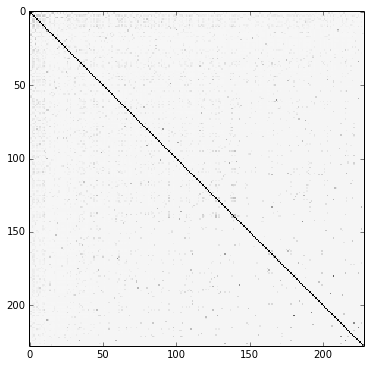

In [9]:
# order nodes by number of messages sent by each participant
o = list(act[fc].sum().order(ascending=False).keys())
plot.draw_adjacency_matrix(G, node_order=o)

In [10]:
from sklearn import cluster

n_clusters = 2
sc = cluster.SpectralClustering(n_clusters=n_clusters)
partition = sc.fit_predict(pc)
partition_order = [fc[x] for x in np.argsort(partition)]

/home/sb/anaconda/envs/bigbang/lib/python2.7/site-packages/sklearn/cluster/spectral.py:421: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


Modularity metric from 

Zanetti, M. and Schweitzer, F. 2012.
        "A Network Perspective on Software Modularity"
        ARCS Workshops 2012, pp. 175-186.

http://arxiv.org/pdf/1201.3771v6.pdf :

* $e_{ij}$ is fraction of edges in network that connect nodes from module $i$ to nodes from module $j$
* $a_i = \sum_{j}^{n} e_{ij}$, $b_i = \sum_{j}^{n} e_{ji}$

$$Q = \frac{\sum_{i}^{n} e_{ii} - \sum_{i}^{n} a_{i}b_{i}}{1 - \sum_{i}^{n} a_{i}b_{i}} $$

Here we are trying to adapt this to edges weighted from $(0,1]$

In [11]:
from bigbang.process import modularity

In [12]:
def get_colors(num):
    return plt.cm.Set1(np.linspace(0, 1, num=num))


def ksc(m, k=3):
    """
    Perform spectral clustering on matrix finding the number of
    clusters that optimizes modularity.
    """

    sc = cluster.SpectralClustering(n_clusters=k)
    partition = sc.fit_predict(pc)

    return partition

In [13]:
partition = ksc(pc, k=3)

In [14]:
partition

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 2,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0], dtype=int32)

In [15]:
partition_order = [fc[x] for x in np.argsort(partition)]
np.sort(partition)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2], dtype=int32)

In [16]:
from collections import defaultdict

p = {}
parts = {}
p_n = {}
mods = []

for k in range(2, 20):
    p[k] = ksc(pc, k=k)

    parts[k] = defaultdict(list)
    p_n[k] = defaultdict(list)

    for i in range(len(p[k])):
        parts[k][p[k][i]].append(fc[i])
        p_n[k][p[k][i]].append(i)

    # print [len(x) for x in p_n[k].values()]

    mod = modularity(pc, list(p_n[k].values()))
    # print mod
    mods.append(mod)

[0.68273829865586444, 0.73119213153041951, 0.61508542073140959, 0.5789327303452666, 0.55223802103348796, 0.58206762553632729, 0.58431430259624972, 0.59199558260411789, 0.59556101446568765, 0.62098559686576504, 0.63134826966808533, 0.62482516308819835, 0.59505523519905168, 0.61695124241799348, 0.65404938597260365, 0.61714630005557225, 0.62284259062970893, 0.60026039039551249]


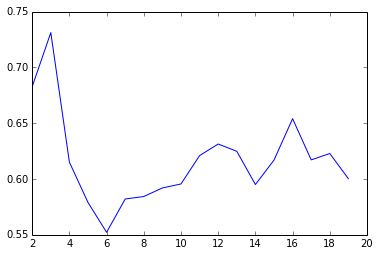

In [17]:
print(mods)
plt.plot(list(range(2, 20)), mods)

In [18]:
k = np.argmax(mods) + 2
partition_order = [fc[x] for x in np.argsort(p[k])]

In [19]:
print(k)
len(list(parts[k].values()))

3


3

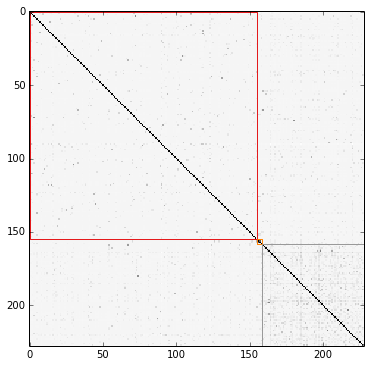

In [20]:
plot.draw_adjacency_matrix(
    G,
    node_order=partition_order,
    partitions=list(parts[k].values()),
    colors=get_colors(k),
)

In [21]:
for x, v in list(parts[k].items()):
    print(str(x) + ": " + str(len(v)))

0: 155
1: 3
2: 70


In [22]:
node_parts = {}

for x, v in list(parts[k].items()):
    for n in v:
        node_parts[n] = int(x)

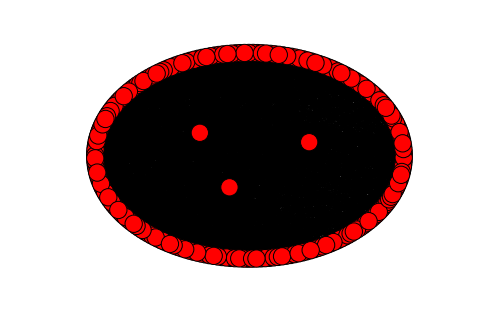

In [23]:
import networkx as nx

# FG = nx.Graph(pc > .01)
FG = nx.from_numpy_matrix(pc * (pc > 0))

labels = dict(enumerate(fc))
FG = nx.relabel_nodes(FG, labels)
nx.set_node_attributes(FG, "corr-cluster", node_parts)


pos = nx.spring_layout(FG, k=0.6, iterations=1000)
nx.draw(FG, pos)
nx.write_gexf(FG, "corr.gexf")

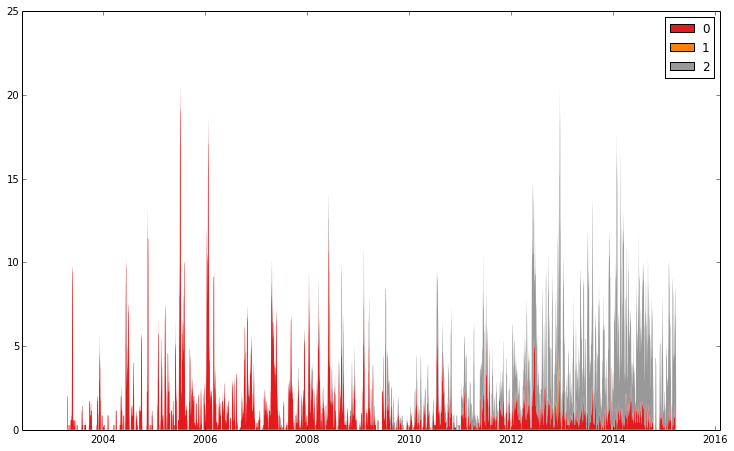

In [24]:
from bigbang import plot

plot.stack(act, partition=parts[k], smooth=7)

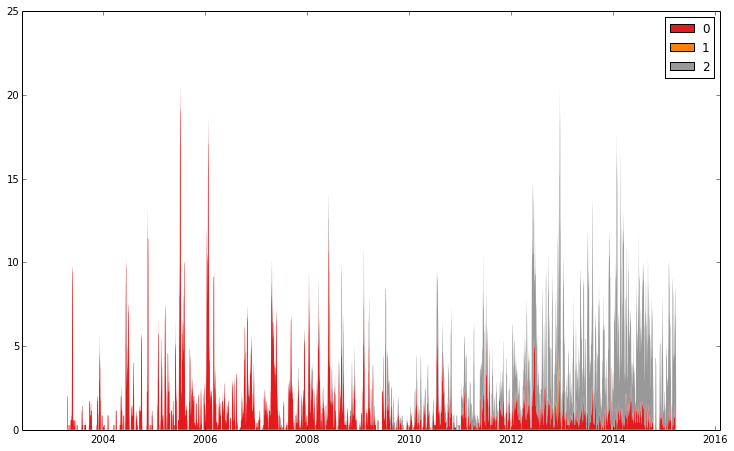

In [25]:
plot.stack(act, partition=parts[3], smooth=7)

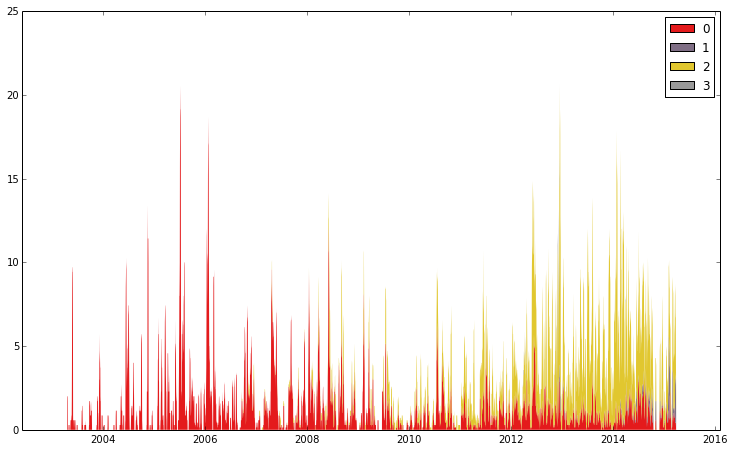

In [26]:
plot.stack(act, partition=parts[4], smooth=7)

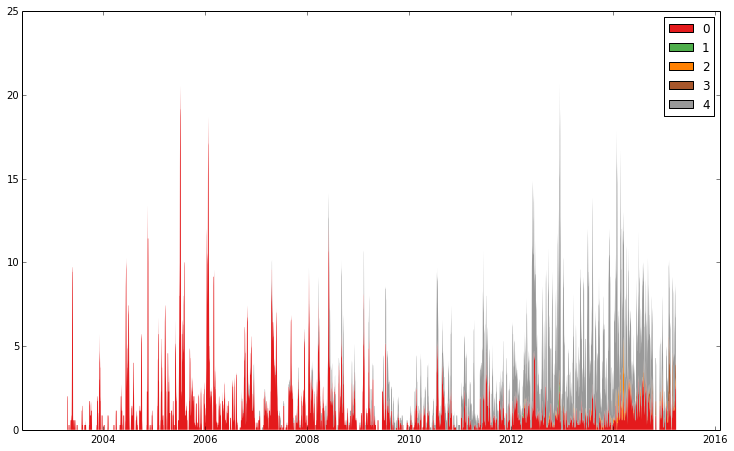

In [27]:
plot.stack(act, partition=parts[5], smooth=7)